## Notebook for cleaning the GSOD data

Author: Wenwen Kong

Updated: 2022-07-20

### About the data
- The GSOD data was downloaded using the R package [GSODR](https://cran.r-project.org/web/packages/GSODR/vignettes/GSODR.html), see [here](https://github.com/wenwenkong/random_collection_r/blob/main/download_GSOD_by_station.R) for an example download script

- Time span: 1973-2021

- Frequency: Daily 

- Downloaded raw data:

    - 722950-23174_KLAX_1973-2021.csv
    - 722886-23130_KVNY_1973-2021.csv
    - 722880-23152_KBUR_1973-2021.csv
    - 722885-99999_KSMO_1973-2005.csv
    - 722885-93197_KSMO_2006-2021.csv
        
- Processed data:

    - GSOD_KLAX_1973-2021_cleaned.csv
    - GSOD_KVNY_1973-2021_cleaned.csv
    - GSOD_KBUR_1973-2021_cleaned.csv
    - GSOD_KSMO_1973-2021_cleaned.csv

### Purpose of this notebook

- Extract variables of interest
- Remove leap days
- Remove duplicated days
- Remove years when 
    - There are >=20% days missing from that year
    - There are >=20% days missing from that summer
- Save the cleaned data 

### Disclaimer:

The method used in this notebook might not be the most efficient way to deal with GSOD.

### Note:

May need to double check the result from KVNY and KSMO

---

### Load in modules 


In [1]:
import numpy as np
from scipy.fft import fft, ifft
import xarray as xr
import sys
import pandas as pd
import glob
import matplotlib.pyplot as plt
import calendar 

---

### Set up parameters


In [2]:
file_names    = ['722880-23152_KBUR_1973-2021.csv', 
                 '722886-23130_KVNY_1973-2021.csv',
                 '722950-23174_KLAX_1973-2021.csv']

station       = ['KBUR', 
                 'KVNY',
                 'KLAX']

years         = list(range(1973, 2022))
yrStart       = years[0]
yrEnd         = years[-1]
days_of_summer= 92
col_list = ['YEARMODA', 'YEAR', 'MONTH', 'DAY','NAME', 'LATITUDE', 'LONGITUDE', 'TEMP', 'MAX', 'MIN']

--- 
### Read in data and print out years that's all missing from data

Helpful solutions for some errors
- [Can only use .dt accessor with datetimelike values](https://stackoverflow.com/questions/33365055/attributeerror-can-only-use-dt-accessor-with-datetimelike-values)
- [Remove leap days](https://stackoverflow.com/questions/54051912/delete-leap-days-in-pandas)

In [3]:
for file, site in zip(file_names, station):
    print("*********************************************************")
    print("******* station = "+site+"  ***********")
    print("*********************************************************")
    
    # ------ all_dfs
    all_dfs = []
    
    # ------ read in data
    df = pd.read_csv(file, usecols = col_list)
    
    # ------ remove leap days
    #df['YEARMODA'] = pd.to_datetime(df['YEARMODA'], errors='coerce')
    #df = df[~((df.YEARMODA.dt.month == 2) & (df.YEARMODA.dt.day == 29))]

    # ------ remove duplicated days if there are any
    df.drop_duplicates(keep = 'first', inplace = True)
    
    # *********************************************************************************
    #    To deal with missing dates, we want to 
    #    (1) either remove rows of years that contains too many missing values
    #    (2) or set missing days with NaN if there are only a few days missed 
    #    
    #    For (1), it's best to remove the rows based on the row label, here we can ues 'YEARMODA' 
    #    For label-based deletion, we set the index first on the dataframe
    # *********************************************************************************
    
    df           = df.set_index('YEARMODA') 
    df.index     = pd.to_datetime(df.index)
    
    for year in years:
        
        days_of_year = 365
        if (calendar.isleap(year)):
            days_of_year = 366

        df_year  = df[df.YEAR == year]
        df_summer= df[(df.YEAR == year) & (df.MONTH >= 6) & (df.MONTH <=8)]
        
        # *********************************************************
        #    Deal with the missing dates
        # *********************************************************
        if len(df_year.DAY) == 0:
            print("--------------------------------------------------------------------")
            print('The whole year of '+str(year)+' is missing')
            
        elif len(df_year.DAY) < 0.8 * days_of_year:
            print("--------------------------------------------------------------------")
            print("Abandon year "+str(year)+" because it has missed more than 20% days")
            df = df[df.YEAR != year]
            #df['TEMP'] = df[df.YEAR != year]['TEMP']
            #df['MAX']  = df[df.YEAR != year]['MAX']
            #df['MIN']  = df[df.YEAR != year]['MIN']
            
        elif len(df_summer.DAY) < 0.8 * days_of_summer:
            print("--------------------------------------------------------------------")
            print("Abandon year "+str(year)+" because it has missed more than 20% days during summer")

            df = df[df.YEAR != year]
            #df['TEMP'] = df[df.YEAR != year]['TEMP']
            #df['MAX']  = df[df.YEAR != year]['MAX']
            #df['MIN']  = df[df.YEAR != year]['MIN']
        
    #df['TEMP'].dropna()
    #df['MAX'].dropna()
    #df['MIN'].dropna()
    df.to_csv('./GSOD_'+site+'_1973-2021_temporary.csv')



*********************************************************
******* station = KBUR  ***********
*********************************************************
--------------------------------------------------------------------
The whole year of 2000 is missing
--------------------------------------------------------------------
The whole year of 2001 is missing
--------------------------------------------------------------------
The whole year of 2002 is missing
--------------------------------------------------------------------
The whole year of 2003 is missing
*********************************************************
******* station = KVNY  ***********
*********************************************************
--------------------------------------------------------------------
Abandon year 1973 because it has missed more than 20% days
--------------------------------------------------------------------
Abandon year 1987 because it has missed more than 20% days
----------------------------

### We now deal with years that contain a small portion of missing days

We read in the temporary .csv from the previous step, and insert missing days with NaN.

In [4]:
for site in station:
    print("*********************************************************")
    print("******* station = "+site+"  ***********")
    print("*********************************************************")
    
    all_dfs = []
    
    df = pd.read_csv('./GSOD_'+site+'_1973-2021_temporary.csv')

    #df['YEARMODA'] = pd.to_datetime(df['YEARMODA'], errors='coerce')
    #df = df[~((df.YEARMODA.dt.month == 2) & (df.YEARMODA.dt.day == 29))]
    
    df           = df.set_index('YEARMODA') 
    df.index     = pd.to_datetime(df.index)
    
    for year in years:
        
        days_of_year = 365
        if (calendar.isleap(year)):
            days_of_year = 366
            
        df_year   = df[df.YEAR == year]
        df_summer = df[(df.YEAR == year) & (df.MONTH >= 6) & (df.MONTH <=8)]
        
        if len(df_year.DAY) < days_of_year and len(df_year.DAY) >= 0.8 * days_of_year:
            print("--------------------------------------------------------------------")
            missed = days_of_year - len(df_year.DAY)
            print("Year "+str(year)+" has "+str(missed)+" missing days")

            date_range        = pd.date_range(start=str(year)+"-01-01", end=str(year)+"-12-31")
            print(date_range.difference(df_year.index))
        
            # ---- fill in the missing dates with a missing value
            df_year    = df_year.reindex(date_range, fill_value=np.nan)
            df_year    = df_year.reindex(date_range, fill_value=np.nan)
            df_year    = df_year.reindex(date_range, fill_value=np.nan)
            
            #df_year.index=pd.to_datetime(df_year.YEAR+df_year.MONTH+df_year.DAY,format="%Y%m%d")
            #df_year['DateTime']  = pd.to_datetime(df_year.YEAR*10000+df_year.MONTH*100+df_year.DAY,format='%Y%m%d')
            #df_year['DateTime'] = pd.to_datetime(df_year['YEARMODA'])
            #df_year = df_year[~((df_year.MONTH == 2) & (df_year.DAY == 29))]
            
            
        all_dfs.append(df_year)
        
    all_dfs_save = pd.concat(all_dfs)
    all_dfs_save = all_dfs_save[~((all_dfs_save.MONTH == 2) & (all_dfs_save.DAY == 29))]
    #all_dfs_save['YEARMODA'] = pd.to_datetime(all_dfs_save['YEARMODA'], errors='coerce')
    #all_dfs_save = all_dfs_save[~((all_dfs_save.YEARMODA.dt.month == 2) & (all_dfs_save.YEARMODA.dt.day == 29))]
    all_dfs_save.to_csv('./GSOD_'+site+'_1973-2021_cleaned.csv')


*********************************************************
******* station = KBUR  ***********
*********************************************************
--------------------------------------------------------------------
Year 1975 has 4 missing days
DatetimeIndex(['1975-05-31', '1975-07-01', '1975-07-02', '1975-07-03'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 1976 has 2 missing days
DatetimeIndex(['1976-07-27', '1976-07-28'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 1978 has 1 missing days
DatetimeIndex(['1978-12-03'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 1982 has 1 missing days
DatetimeIndex(['1982-02-21'], dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 1986 has 1 missing days
DatetimeIndex(['1986-04-21'], dtype='datet

--- 

### KSMO is a bit different, so we deal with it separately

In [5]:
files = ['722885-99999_KSMO_1973-2005.csv','722885-93197_KSMO_2006-2021.csv']

KSMO_df = []

for f in files:
    
    df  = pd.read_csv(f)
    
    KSMO_df.append(df)

KSMO    = pd.concat(KSMO_df)
KSMO.to_csv('./GSOD_KSMO_1973-2021_combined.csv')

In [6]:
print("*********************************************************")
print("******* station = KSMO  ***********")
print("*********************************************************")
    
# ------ all_dfs
all_dfs = []
    
# ------ read in data
df = pd.read_csv('./GSOD_KSMO_1973-2021_combined.csv', usecols = col_list)
    
# ------ remove duplicated days if there are any
df.drop_duplicates(keep = 'first', inplace = True)
    
# *********************************************************************************
#    To deal with missing dates, we want to 
#    (1) either remove rows of years that contains too many missing values
#    (2) or set missing days with NaN if there are only a few days missed 
#    
#    For (1), it's best to remove the rows based on the row label, here we can ues 'YEARMODA' 
#    For label-based deletion, we set the index first on the dataframe
# *********************************************************************************
    
df           = df.set_index('YEARMODA') 
df.index     = pd.to_datetime(df.index)
    
for year in years:
        
    days_of_year = 365
    if (calendar.isleap(year)):
        days_of_year = 366

    df_year  = df[df.YEAR == year]
    df_summer= df[(df.YEAR == year) & (df.MONTH >= 6) & (df.MONTH <=8)]
        
    # *********************************************************
    #    Deal with the missing dates
    # *********************************************************
    if len(df_year.DAY) == 0:
        print("--------------------------------------------------------------------")
        print('The whole year of '+str(year)+' is missing')
            
    elif len(df_year.DAY) < 0.8 * days_of_year:
        print("--------------------------------------------------------------------")
        print("Abandon year "+str(year)+" because it has missed more than 20% days")
        df = df[df.YEAR != year]
            #df['TEMP'] = df[df.YEAR != year]['TEMP']
            #df['MAX']  = df[df.YEAR != year]['MAX']
            #df['MIN']  = df[df.YEAR != year]['MIN']
            
    elif len(df_summer.DAY) < 0.8 * days_of_summer:
        print("--------------------------------------------------------------------")
        print("Abandon year "+str(year)+" because it has missed more than 20% days during summer")

        df = df[df.YEAR != year]
            #df['TEMP'] = df[df.YEAR != year]['TEMP']
            #df['MAX']  = df[df.YEAR != year]['MAX']
            #df['MIN']  = df[df.YEAR != year]['MIN']
        
    #df['TEMP'].dropna()
    #df['MAX'].dropna()
    #df['MIN'].dropna()
df.to_csv('./GSOD_KSMO_1983-2021_temporary.csv')

*********************************************************
******* station = KSMO  ***********
*********************************************************
--------------------------------------------------------------------
The whole year of 1973 is missing
--------------------------------------------------------------------
The whole year of 1974 is missing
--------------------------------------------------------------------
Abandon year 1975 because it has missed more than 20% days
--------------------------------------------------------------------
The whole year of 1976 is missing
--------------------------------------------------------------------
The whole year of 1977 is missing
--------------------------------------------------------------------
The whole year of 1978 is missing
--------------------------------------------------------------------
The whole year of 1979 is missing
--------------------------------------------------------------------
The whole year of 1980 is missing

In [7]:
print("*********************************************************")
print("******* station = KSMO  ***********")
print("*********************************************************")
    
all_dfs = []
    
df = pd.read_csv('./GSOD_KSMO_1983-2021_temporary.csv')

    
df           = df.set_index('YEARMODA') 
df.index     = pd.to_datetime(df.index)
    
for year in years:
        
    days_of_year = 365
    if (calendar.isleap(year)):
        days_of_year = 366
            
    df_year   = df[df.YEAR == year]
    df_summer = df[(df.YEAR == year) & (df.MONTH >= 6) & (df.MONTH <=8)]
        
    if len(df_year.DAY) < days_of_year and len(df_year.DAY) >= 0.8 * days_of_year:
        print("--------------------------------------------------------------------")
        missed = days_of_year - len(df_year.DAY)
        print("Year "+str(year)+" has "+str(missed)+" missing days")

        date_range        = pd.date_range(start=str(year)+"-01-01", end=str(year)+"-12-31")
        print(date_range.difference(df_year.index))
        
        # ---- fill in the missing dates with a missing value
        df_year    = df_year.reindex(date_range, fill_value=np.nan)
        df_year    = df_year.reindex(date_range, fill_value=np.nan)
        df_year    = df_year.reindex(date_range, fill_value=np.nan)
            
            #df_year.index=pd.to_datetime(df_year.YEAR+df_year.MONTH+df_year.DAY,format="%Y%m%d")
            #df_year['DateTime']  = pd.to_datetime(df_year.YEAR*10000+df_year.MONTH*100+df_year.DAY,format='%Y%m%d')
            #df_year['DateTime'] = pd.to_datetime(df_year['YEARMODA'])
            #df_year = df_year[~((df_year.MONTH == 2) & (df_year.DAY == 29))]
            
            
    all_dfs.append(df_year)
        
all_dfs_save = pd.concat(all_dfs)
all_dfs_save = all_dfs_save[~((all_dfs_save.MONTH == 2) & (all_dfs_save.DAY == 29))]
#all_dfs_save['YEARMODA'] = pd.to_datetime(all_dfs_save['YEARMODA'], errors='coerce')
#all_dfs_save = all_dfs_save[~((all_dfs_save.YEARMODA.dt.month == 2) & (all_dfs_save.YEARMODA.dt.day == 29))]
all_dfs_save.to_csv('./GSOD_KSMO_1983-2021_cleaned.csv')

*********************************************************
******* station = KSMO  ***********
*********************************************************
--------------------------------------------------------------------
Year 1983 has 28 missing days
DatetimeIndex(['1983-01-29', '1983-01-30', '1983-01-31', '1983-02-01',
               '1983-02-02', '1983-02-03', '1983-02-04', '1983-02-05',
               '1983-02-06', '1983-02-07', '1983-02-08', '1983-09-29',
               '1983-09-30', '1983-12-17', '1983-12-18', '1983-12-19',
               '1983-12-20', '1983-12-21', '1983-12-22', '1983-12-23',
               '1983-12-24', '1983-12-25', '1983-12-26', '1983-12-27',
               '1983-12-28', '1983-12-29', '1983-12-30', '1983-12-31'],
              dtype='datetime64[ns]', freq=None)
--------------------------------------------------------------------
Year 1984 has 23 missing days
DatetimeIndex(['1984-01-01', '1984-01-02', '1984-01-03', '1984-01-04',
               '1984-01-05', '19

---
### Using the cleaned data, now we obtain the seasonal cycle and daily anomalies and save to a new file


#### Define useful functions

In [11]:
cols = ['YEAR', 'MONTH', 'DAY','NAME', 'LATITUDE', 'LONGITUDE', 'TEMP', 'MAX', 'MIN']
def get_clim(f):
    """
    Generate the empericial daily climatology.
    This will be used to get the FFT filter.
    """
    
    # --- read in the .csv file
    df = pd.read_csv(f, usecols = cols)
    
    # --- calculate the emperical daily climatology
    df['TEMP_emperical_clim']   = df.groupby(['MONTH', 'DAY'])['TEMP'].transform('mean')
    df['MAX_emperical_clim']    = df.groupby(['MONTH', 'DAY'])['MAX'].transform('mean')
    df['MIN_emperical_clim']    = df.groupby(['MONTH', 'DAY'])['MIN'].transform('mean')
    return df
    

In [12]:
def get_fft(df, var):
    """
    Obtain the first four harmonics of FFT as seasonal cycle 
    Obtain the anomalies with the FFT filtered seasonal cycle removed
    """
    
    df_array = np.array(df[var])
    df_clim  = df_array[0:365]
    
    ntime    = 365
    nharms   = 4
    
    temp_fft    = fft(df_clim, axis = 0)
    temp_fft2   = np.zeros_like(temp_fft)
    
    temp_fft2[0:nharms]               = temp_fft[0:nharms]
    temp_fft2[ntime-nharms+1:ntime+1] = temp_fft[ntime-nharms+1:ntime+1]
    
    df_seasonalcycle   = xr.DataArray(np.real(ifft(temp_fft2, axis=0)))
    
    repeats     = int(len(df[var]) / 365)
    repeats_list= []
    
    for i in range(0,repeats):
        repeats_list.extend(df_seasonalcycle)
    
    return xr.DataArray(repeats_list)
    

#### Loop through the station list and save the new file

In [14]:
stations = ['KLAX', 
            'KBUR', 
            'KVNY', 
            'KSMO']

files_in = ['GSOD_KLAX_1973-2021_cleaned.csv', 
            'GSOD_KBUR_1973-2021_cleaned.csv', 
            'GSOD_KVNY_1973-2021_cleaned.csv', 
            'GSOD_KSMO_1983-2021_cleaned.csv']

files_out = ['GSOD_KLAX_1973-2021_TEMP_MAX_MIN.csv', 
             'GSOD_KBUR_1973-2021_TEMP_MAX_MIN.csv', 
             'GSOD_KVNY_1973-2021_TEMP_MAX_MIN.csv', 
             'GSOD_KSMO_1983-2021_TEMP_MAX_MIN.csv']

for site, f_in, f_out in zip(stations, files_in, files_out):
    print('----- '+ site +' ------')
    df = get_clim(f_in)
    
    df['TEMP_fft_clim'] = get_fft(df, 'TEMP_emperical_clim')
    df['MAX_fft_clim']  = get_fft(df, 'MAX_emperical_clim')
    df['MIN_fft_clim']  = get_fft(df, 'MIN_emperical_clim')
    
    df['TEMP_fft_anom'] = df['TEMP'] - df['TEMP_fft_clim']
    df['MAX_fft_anom']  = df['MAX'] - df['MAX_fft_clim']
    df['MIN_fft_anom']  = df['MIN'] - df['MIN_fft_clim']
    
    df.to_csv(f_out)

----- KLAX ------
----- KBUR ------
----- KVNY ------
----- KSMO ------


---
#### Visualization

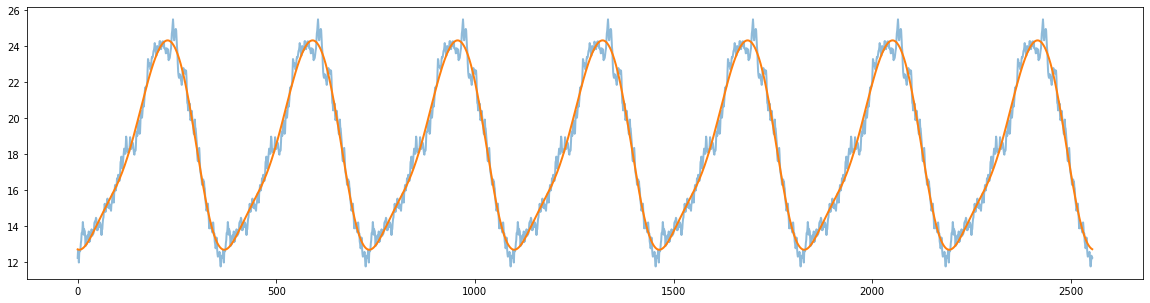

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))

df_KBUR = pd.read_csv('GSOD_KBUR_1973-2021_TEMP_MAX_MIN.csv')
df_KBUR[df_KBUR.YEAR < 1980]['TEMP_emperical_clim'].plot(ax = ax, lw = 2, color = 'tab:blue', alpha = .5)
df_KBUR[df_KBUR.YEAR < 1980]['TEMP_fft_clim'].plot(ax = ax, lw = 2, color = 'tab:orange', alpha = 1.0)



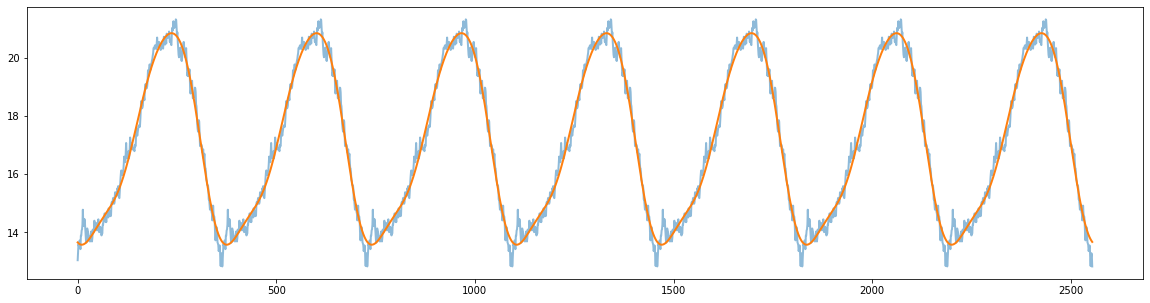

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
df_KLAX = pd.read_csv('GSOD_KLAX_1973-2021_TEMP_MAX_MIN.csv')
df_KLAX[df_KLAX.YEAR < 1980]['TEMP_emperical_clim'].plot(ax = ax, lw = 2, color = 'tab:blue', alpha = .5)
df_KLAX[df_KLAX.YEAR < 1980]['TEMP_fft_clim'].plot(ax = ax, lw = 2, color = 'tab:orange', alpha = 1.0)

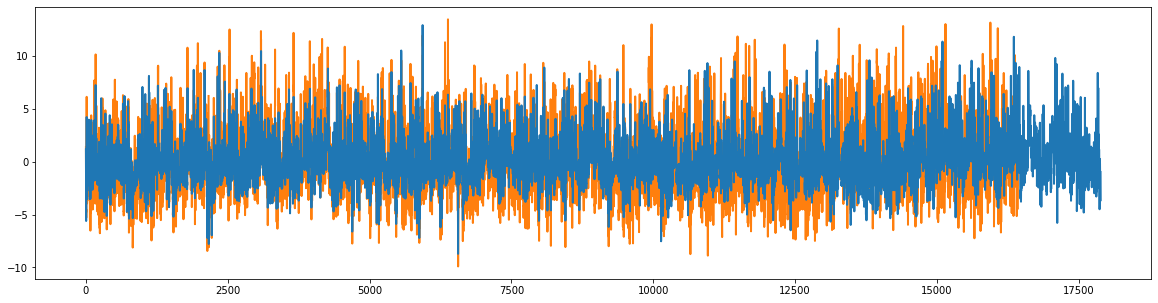

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(20,5))
df_KBUR['TEMP_fft_anom'].plot(ax = ax, lw = 2, color = 'tab:orange', alpha = 1.0)
df_KLAX['TEMP_fft_anom'].plot(ax = ax, lw = 2, color = 'tab:blue', alpha = 1.0)